# Multi Layer Perceptron

This is the Notebook used for the Implementation, Training and Testing of a numpy-based Multi Layer Perceptron classifier.

## Importing Data - Preparation

Separating data into training, validation and testing. This process uses the Scikit-Learn [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) class.

In [15]:
# import numpy as np
# from sklearn.datasets import make_regression

# # Reproducibility
# rng = np.random.RandomState(42)

# def sample_regression_subset(
#     n_needed: int,
#     n_features: int,
#     seed: int,
#     *,
#     n_informative: int = None,
#     bias: float = 0.0,
#     noise: float = 10.0,
#     coef_range: tuple = (1.0, 5.0),
#     cluster_shift: float = 0.0,
# ):
#     """
#     Generate a synthetic regression subset with a controllable shift/noise pattern.
#     Each call can represent one 'region' or 'cluster' of data with its own difficulty.
#     """
#     if n_informative is None:
#         n_informative = n_features

#     X, y, coef = make_regression(
#         n_samples=n_needed,
#         n_features=n_features,
#         n_informative=n_informative,
#         noise=noise,
#         bias=bias,
#         coef=True,
#         random_state=seed,
#     )

#     # Add random coefficient scaling to diversify clusters
#     coef_scale = rng.uniform(*coef_range, size=n_features)
#     y = X @ (coef * coef_scale) + bias + rng.randn(n_needed) * noise

#     # Shift features to form separated clusters
#     X += cluster_shift

#     return X, y


# # ---------- Build an asymmetric multi-cluster regression dataset ----------
# N = 1500
# n_features = 14
# clusters = [
#     dict(n_needed=500, noise=5.0,  bias=20.0,  cluster_shift=-2.0, seed=42),
#     dict(n_needed=500, noise=10.0, bias=-15.0, cluster_shift=0.0,  seed=1337),
#     dict(n_needed=500, noise=15.0, bias=35.0,  cluster_shift=+2.0, seed=2027),
# ]

# Xs, ys = [], []
# for cfg in clusters:
#     Xi, yi = sample_regression_subset(n_features=n_features, **cfg)
#     Xs.append(Xi)
#     ys.append(yi)

# # Combine and shuffle
# X = np.vstack(Xs)
# y = np.concatenate(ys)
# perm = rng.permutation(len(y))
# X = X[perm]
# y = y[perm]

# print("X shape:", X.shape, "y shape:", y.shape)
# print("Feature means (first 5):", X.mean(axis=0)[:5])
# print("Target stats: mean={:.3f}, std={:.3f}".format(y.mean(), y.std()))


In [16]:
import pandas as pd
df = pd.read_csv('./data/students_performance/StudentsPerformance_refined.csv')


X = df.drop(columns=['math score'])
y = df['math score']

In [17]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, LabelEncoder
from sklearn.impute import SimpleImputer



X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)



print("Shapes:", X_train.shape, X_test.shape)
# X_train.min()/max() returns a Series (one per column). To get the overall min/max use values.min()/values.max()
print("Value range (train):", X_train.values.min(), "to", X_train.values.max())




Shapes: (800, 14) (200, 14)
Value range (train): 0 to 100


In [18]:
#Apply min-max scaling to features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# === Funções auxiliares ===
def glorot_uniform(fan_in, fan_out):
    limit = np.sqrt(6.0 / (fan_in + fan_out))
    return np.random.uniform(-limit, limit, size=(fan_out, fan_in))

def init_vector_glorot(fan_out):
    return np.zeros(fan_out)

# Usada apenas para classificação multiclasse
# def softmax(z):
#     z = z - np.max(z)
#     e = np.exp(z)
#     return e / np.sum(e)

# Função de perda para regressão
def mse(y_true, y_pred):
    # both shaped (K,) where K=1 for single target
    return 0.5 * np.mean((y_pred - y_true)**2)

def one_hot(y_i, K):
    v = np.zeros(K, dtype=float)
    v[y_i] = 1.0
    return v

def cross_entropy(y_true_one_hot, p):
    return -np.sum(y_true_one_hot * np.log(p + 1e-12))

tanh = np.tanh
tanhp = lambda a: (1.0 - a**2)

# === Classe da camada ===
class HiddenLayer:
    def __init__(self, fan_in, fan_out):
        self.W = glorot_uniform(fan_in, fan_out)
        self.b = init_vector_glorot(fan_out)
        self.z = None
        self.a = None
        self.prev_a = None
        self.tanh = np.tanh

    def forward(self, x):
        self.prev_a = x
        self.z = self.W @ x + self.b
        self.a = self.tanh(self.z)
        return self.a

# === Forward total ===
def forward_probs(x, layers, W2, b2):
    a = x
    for layer in layers:
        a = layer.forward(a)
    z2 = W2 @ a + b2
    # Para problemas de classificação, usar softmax na saída
    # p = softmax(z2
    p = z2
    return p, a


# === Configuração da rede ===
K = 1                 
input_dim = X_train.shape[1]
H = 16
NLayers = 3

HiddenLayers = []
HiddenLayers.append(HiddenLayer(input_dim, H))
for _ in range(NLayers - 1):
    HiddenLayers.append(HiddenLayer(H, H))

W2 = glorot_uniform(H, K)
b2 = np.zeros(K)

eta = 0.01     
epochs = 100
clip_value = 5.0

N = len(X_train)
indices = np.arange(N)

# === Histórico para gráficos ===

# Apenas para classificação multiclasse
# train_acc_history = []

train_loss_history = []
# Opção 1 (mais simples e direta)
# X_train = X_train.to_numpy()
# y_train = y_train.to_numpy()

# Converter para numpy float
X_train = np.asarray(X_train, dtype=float)
X_test = np.asarray(X_test, dtype=float)
y_train = np.asarray(y_train, dtype=float)
y_test = np.asarray(y_test, dtype=float)


# === Loop de treino ===
for epoch in range(epochs):

    np.random.shuffle(indices)
    total_loss = 0.0

    for idx in indices:
        
        # pegar amostra
        x_i = X_train[idx]
        y_i = np.asarray(y_train[idx], dtype=float).reshape(-1) 

        # forward classficação multiclasses
        # p, a_last = forward_probs(x_i, HiddenLayers, W2, b2)
        # y_one = one_hot(y_i, K)
        # total_loss += cross_entropy(y_one, p)
        
        #  forward regressão
        y_hat, a_last = forward_probs(x_i, HiddenLayers, W2, b2)
        Tdim = y_i.size  # = 1
        delta_out = (y_hat - y_i) / Tdim  
        
        
        # grads output
        dW2 = np.outer(delta_out, a_last)
        db2 = delta_out
        W2_old = W2.copy()

        next_delta = delta_out
        next_W = W2_old

        # backward hidden
        for layer in reversed(HiddenLayers):
            g = next_W.T @ next_delta
            delta = g * tanhp(layer.a)
            dW = np.outer(delta, layer.prev_a)
            db = delta

            W_old = layer.W.copy()

            # gradient clipping
            if np.linalg.norm(dW) > clip_value:
                dW *= clip_value / (np.linalg.norm(dW) + 1e-12)
            if np.linalg.norm(db) > clip_value:
                db *= clip_value / (np.linalg.norm(db) + 1e-12)

            layer.W -= eta * dW
            layer.b -= eta * db

            next_delta = delta
            next_W = W_old

        # update output layer
        if np.linalg.norm(dW2) > clip_value:
            dW2 *= clip_value / (np.linalg.norm(dW2) + 1e-12)
        if np.linalg.norm(db2) > clip_value:
            db2 *= clip_value / (np.linalg.norm(db2) + 1e-12)

        W2 -= eta * dW2
        b2 -= eta * db2

    # === Avaliação após cada época ===

    # == Para modelos de classificação multiclasses
    
    # probs = np.array([forward_probs(x_i, HiddenLayers, W2, b2)[0] for x_i in X_train])
    # y_pred = np.argmax(probs, axis=1)
    
    # acc = accuracy_score(y_train, y_pred)
    # loss = np.mean([-np.log(probs[i, y_train[i]] + 1e-12) for i in range(len(y_train))])
    
    # train_acc_history.append(acc)
    # train_loss_history.append(loss)
    
    # print(f"Epoch {epoch:03d} | train acc: {acc:.4f} | train loss: {loss:.4f}")
    
    # == para modelos de regressão
    
    preds = np.array([forward_probs(x_i, HiddenLayers, W2, b2)[0][0] for x_i in X_train])
    y_true = y_train.astype(float)
    
    rmse = np.sqrt(np.mean((preds - y_true)**2))
    mae  = np.mean(np.abs(preds - y_true))
    
    # R**2 (against zero variance)
    var = np.var(y_true)
    r2 = 1.0 - np.mean((preds - y_true)**2) / (var + 1e-12)

    train_loss_history.append(rmse)
    print(f"Epoch {epoch:03d} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f}")


print("Final W2:", W2, "Final b2:", b2)
for i, layer in enumerate(HiddenLayers, 1):
    print(f"Layer {i} weights:\n{layer.W}\nLayer {i} bias:\n{layer.b}")


Epoch 000 | RMSE: 15.0517 | MAE: 11.9828 | R2: -0.0049
Epoch 001 | RMSE: 14.7030 | MAE: 11.7176 | R2: 0.0411
Epoch 002 | RMSE: 9.1070 | MAE: 7.1844 | R2: 0.6321
Epoch 003 | RMSE: 7.3808 | MAE: 5.7952 | R2: 0.7584
Epoch 004 | RMSE: 7.2866 | MAE: 5.8519 | R2: 0.7645
Epoch 005 | RMSE: 6.4746 | MAE: 5.1085 | R2: 0.8141
Epoch 006 | RMSE: 6.3819 | MAE: 5.0825 | R2: 0.8193
Epoch 007 | RMSE: 7.9666 | MAE: 6.5363 | R2: 0.7185
Epoch 008 | RMSE: 8.6668 | MAE: 7.1872 | R2: 0.6668
Epoch 009 | RMSE: 8.5960 | MAE: 7.1889 | R2: 0.6722
Epoch 010 | RMSE: 7.1663 | MAE: 5.7738 | R2: 0.7722
Epoch 011 | RMSE: 6.1463 | MAE: 4.7653 | R2: 0.8324
Epoch 012 | RMSE: 6.4699 | MAE: 5.1553 | R2: 0.8143
Epoch 013 | RMSE: 6.6588 | MAE: 5.2915 | R2: 0.8033
Epoch 014 | RMSE: 6.2646 | MAE: 4.9650 | R2: 0.8259
Epoch 015 | RMSE: 5.7096 | MAE: 4.4785 | R2: 0.8554
Epoch 016 | RMSE: 6.9582 | MAE: 5.6032 | R2: 0.7852
Epoch 017 | RMSE: 5.5449 | MAE: 4.3583 | R2: 0.8636
Epoch 018 | RMSE: 5.9699 | MAE: 4.7348 | R2: 0.8419
Epoch 0

In [20]:

preds = np.array([forward_probs(x_i, HiddenLayers, W2, b2)[0][0] for x_i in X_train])
y_true = y_train.astype(float)

rmse = np.sqrt(np.mean((preds - y_true)**2))
print("Training RMSE:", rmse)

Training RMSE: 4.66289421588012


## Regression Metrics

In [21]:
import numpy as np
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    median_absolute_error,
)
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

def regression_report(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    *,
    n_features: int,
    sample_weight: np.ndarray | None = None,
    mape_epsilon: float = 1e-8,
) -> dict:
    """
    Compute and print a set of regression metrics:
      - MAE, MSE, RMSE
      - MAPE (safe for zeros in y_true via epsilon)
      - R^2 (coefficient of determination)
      - Adjusted R^2
      - Median Absolute Error (MedAE)

    Parameters
    ----------
    y_true : array-like, shape (n_samples,)
    y_pred : array-like, shape (n_samples,)
    n_features : int
        Number of predictors used by the model (for Adjusted R^2).
    sample_weight : array-like or None
        Optional sample weights for all metrics that support it.
    mape_epsilon : float
        Small constant to avoid division by zero in MAPE denominator.

    Returns
    -------
    metrics : dict
        Dictionary with all computed metrics.
    """
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()

    if y_true.shape != y_pred.shape:
        raise ValueError(f"Shape mismatch: y_true {y_true.shape} vs y_pred {y_pred.shape}")

    n = y_true.size
    p = int(n_features)

    # Core metrics
    mae = mean_absolute_error(y_true, y_pred, sample_weight=sample_weight)
    mse = mean_squared_error(y_true, y_pred, sample_weight=sample_weight)
    rmse = np.sqrt(mse)

    # Safe MAPE (handles zeros by clamping denominator with epsilon)
    denom = np.maximum(np.abs(y_true), mape_epsilon)
    mape = np.mean(np.abs((y_true - y_pred) / denom)) * 100.0

    # R² and Adjusted R²
    r2 = r2_score(y_true, y_pred, sample_weight=sample_weight)

    # Guard for small n relative to p
    if n > p + 1:
        adj_r2 = 1.0 - (1.0 - r2) * (n - 1) / (n - p - 1)
    else:
        adj_r2 = np.nan  # Not defined if n <= p + 1

    # Median absolute error
    medae = median_absolute_error(y_true, y_pred)

    # Print nicely
    print("\n=== Regression Metrics ===")
    print(f"Samples (n): {n} | Features (p): {p}")
    print(f"MAE   (Mean Absolute Error):       {mae:.6f}")
    print(f"MSE   (Mean Squared Error):        {mse:.6f}")
    print(f"RMSE  (Root Mean Squared Error):   {rmse:.6f}")
    zero_count = int(np.sum(np.isclose(y_true, 0.0)))
    print(f"MAPE  (Mean Abs % Error):          {mape:.6f}%   "
          f"(handled zeros in y_true: {zero_count})")
    print(f"R²    (Coeff. of Determination):   {r2:.6f}")
    print(f"Adj R² (Adjusted R-squared):       {adj_r2:.6f}")
    print(f"MedAE (Median Absolute Error):     {medae:.6f}")
    
    
y_pred = np.array([forward_probs(x_i, HiddenLayers, W2, b2)[0][0] for x_i in X_test])
y_true = y_test.astype(float)
regression_report(y_true, y_pred, n_features=X.shape[1])



=== Regression Metrics ===
Samples (n): 200 | Features (p): 14
MAE   (Mean Absolute Error):       5.295170
MSE   (Mean Squared Error):        46.145941
RMSE  (Root Mean Squared Error):   6.793080
MAPE  (Mean Abs % Error):          847444279.946887%   (handled zeros in y_true: 1)
R²    (Coeff. of Determination):   0.810363
Adj R² (Adjusted R-squared):       0.796012
MedAE (Median Absolute Error):     4.582553


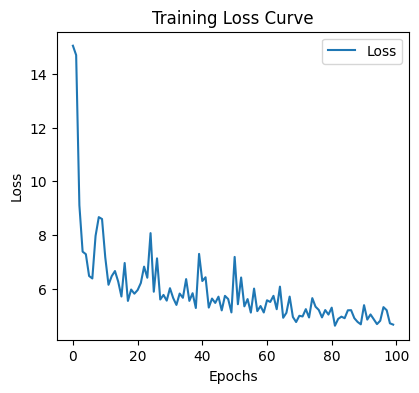

In [22]:
# === Plots ===
plt.figure(figsize=(10,4))

# Loss curve
plt.subplot(1,2,1)
plt.plot(train_loss_history, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()

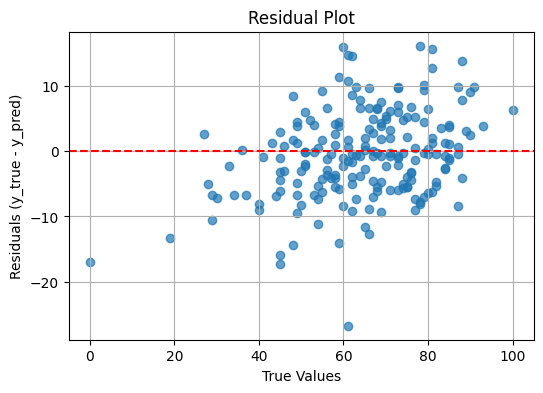

In [23]:
residuals = y_true - y_pred

plt.figure(figsize=(6,4))
plt.scatter(y_true, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Residuals (y_true - y_pred)')
plt.title('Residual Plot')
plt.grid(True)
plt.show()
